# PyTorch Neural Network
## Author: Rohan Singh
This Python Notebook contains source code for a PyTorch Neural Network Demonstration.

## Libraries Used

In [1]:
# EDA Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Data Loading Libraries to use the entire iris dataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# PyTorch Libraries
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import tqdm

## Loading Data

### Loading the Iris Dataset

In [2]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

### Train-Test split
This split is done to ensure that the model doesn't overfit the dataset

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

## Model Configuration
Configuring the PyTorch model by defining the device on which it will be trained, the hidden layers and activation functions for the model as well as the loss function and optimziers used while training the model.

### Selecting the device
It is more efficient to train PyTorch NNs on GPUs. In order to make sure it runs on you local device, I have added a statement to select the appropriate computing device of the TAs, i.e. it selects CUDA (if avaliable) as its first choice, followed by MPS (if it is a mac) and if it doesn't find either of them it will just run on the CPU.

In [4]:
# Selecting the appropriate
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### Defining the Neural Network
In this subsection we will be defining the properties of the hidden layers of the neural networks, such as teh number of layers, the number (i.e. the dimenstions) of hidden units per layer and the activation function type. 

The number of layers as well as the dimensions of these layers in the Neural Network are defined in the initialization function of the Neural Network Class.

The activation functions of the network are defined in the forward function.

In [5]:

class IrisModel(nn.Module):

    # Initialization function for our NN
    def __init__(self, input_dim, output_dim):

        # Initializing the parent class for Torch's Neural Network
        super(IrisModel, self).__init__()

        # The first layer is in between the input and 1st hidden layer
        self.layer1 = nn.Linear(input_dim, 50)

        # The second layer lies between the 2 hidden layers
        self.layer2 = nn.Linear(50, 50)

        # This layer is between the 2nd hidden layer and the output layer
        self.layer3 = nn.Linear(50, output_dim)
        
        
    # Initizialing the hidden Layers
    def forward(self, x):

        # Using RELU for the first 2 hidden layers
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
       

        # Using Softmax for the final hidden layer, so that it chooses only one label from the output vector
        x = F.softmax(self.layer3(x), dim=1)
        return x

### Defining the optimizer and the loss function
In order for us to train our network, in this section we will define the loss function as well as the optimizer to optimize the chosen lost function for us.

In [6]:
model     = IrisModel(X_train.shape[1], 3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
model

IrisModel(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

## Training the Model
In this section we will train our model over 100 epochs. Additionally, we will be storing the validation loss as well as the accuracy for each epoch so that we can plot it later

In [7]:
EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [00:00<00:00, 545.13it/s]


## Plotting the accuracy and loss with each epoch

Text(0.5, 0, 'epochs')

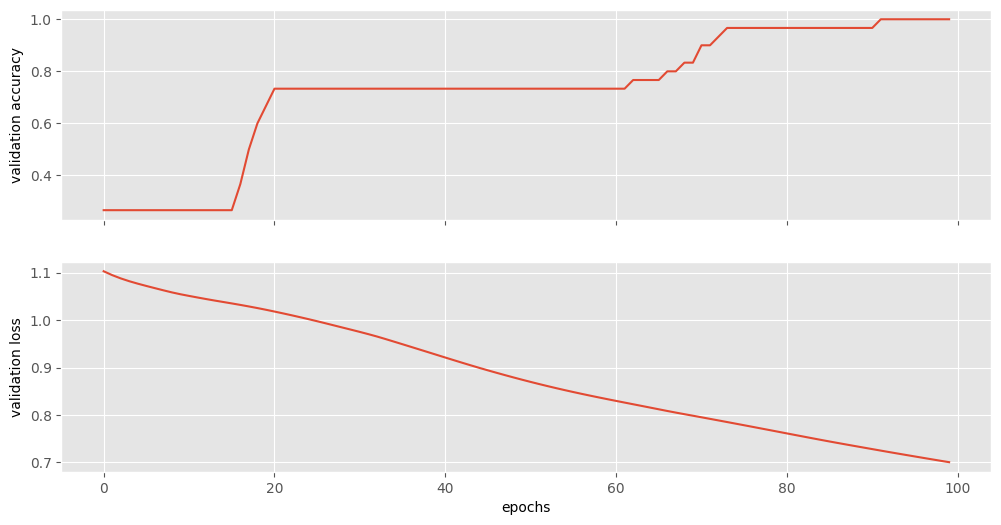

In [8]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs")

## KMeans Using Scikit learn
This section contains code for the KMeans clustering algorithm using scikit-learn. This section will be used to compare results with the PyTorch neural network that we used in the previous sections.

### Loading the dataset

In [9]:
# Load Iris dataset
iris = load_iris()
X = iris.data

### Setting up the KMeans classifier
Just like the Neural Network we have to define some properties of the KMeans classifier

In [10]:
optimal_k = 3

# Perform KMeans clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)

/Users/rohansingh/opt/anaconda3/envs/machinelearning/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

### Plotting the results

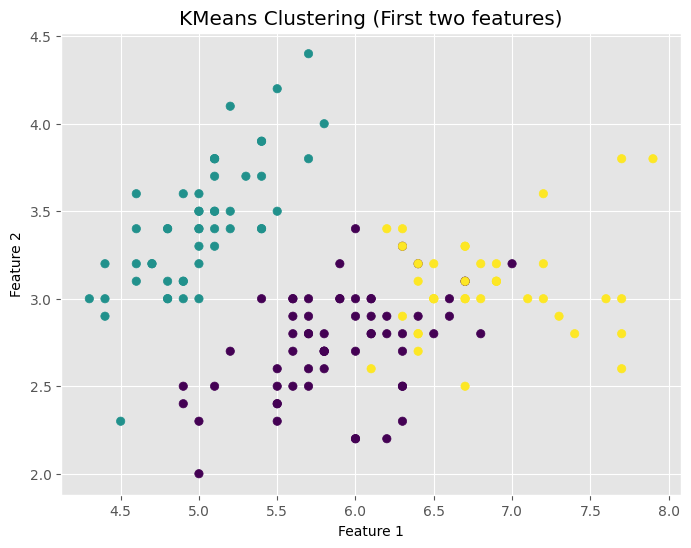

In [11]:
# Visualize the clusters using the first two features for plotting purposes
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('KMeans Clustering (First two features)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Getting the Silouette Score
In this subsection we will get the silhouette score to obtain the accuracy of the KMeans classifier. The Silhouette score of 0.55 is not the best score, as a good score is usually much closer to 1, so KMeans is not the most ideal classifier in this case.

In [12]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5528190123564094
